In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
from torch.utils.data import Subset, DataLoader
from sklearn.decomposition import PCA
sys.path.append("../hyperLAI")
sys.path.append("../../")
from utils.model_utils import *
from features.hyperLAIdataset import HyperLoader
from models.fc_model import fc_model
from HypHC.utils.visualization import plot_tree_from_leaves
from tqdm import tqdm_notebook

In [15]:
def plot_weights_pca(embeddings, labels, annotations=None):
    '''
    Plot PCA of embedding
    '''
    weights_pca = PCA().fit_transform(embeddings)
    scplot = sns.scatterplot(x=weights_pca[:,0], y=weights_pca[:,1], hue=labels)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA of Embedding Weights")
    if annotations is not None:
        for line in range(len(labels)):
#             if weights_pca[line,1] > -0.3:
#             if annotations[line] != "Bengali":
#                 continue
            scplot.text(weights_pca[line,0]+0.005, weights_pca[line,1], 
                         annotations[line], horizontalalignment='left', color='black', size=8)


In [3]:
model_dir = "/scratch/users/patelas/hyperLAI/models/fc_models/scratch/fc_experiments/lr_negthree_temp_negfour_500k_filter_africans_allchr/"
config = read_config(model_dir + "fc_config.json")

In [4]:
dataset = HyperLoader(config["data_dir"], config["restrict_labels"], config["chromosome"])
train_indices, valid_indices, test_indices = train_valid_test(len(dataset), config["train_perc"], config["valid_perc"])
# variance_filter(dataset, train_indices, config["variance_filter"])
valid_data = Subset(dataset, valid_indices)
valid_loader = DataLoader(valid_data, batch_size=64)

In [5]:
model = fc_model(dataset.snps.shape[1], config["num_int_layers"], config["int_layer_sizes"], config["embedding_size"], 
                 config["dropout_vals"], config["temperature"], config["init_size"], config["min_scale"], config["max_scale"])
model_info = torch.load("%smodel.pt"%(model_dir))
model.load_state_dict(model_info["model_state"])


<All keys matched successfully>

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
model.eval()
embeddings, suppop_labels, pop_labels = [], [], []
with torch.no_grad():
    for i, (snp_data, suppop, pop) in enumerate(valid_loader):
        embs = model(snp_data.float().to(device))
        embeddings.append(embs.cpu())
        suppop_labels.append(suppop)
        pop_labels.append(pop)

In [7]:
embeddings = torch.cat(embeddings).numpy()
suppop_labels = torch.cat(suppop_labels).numpy()
pop_labels = torch.cat(pop_labels).numpy()

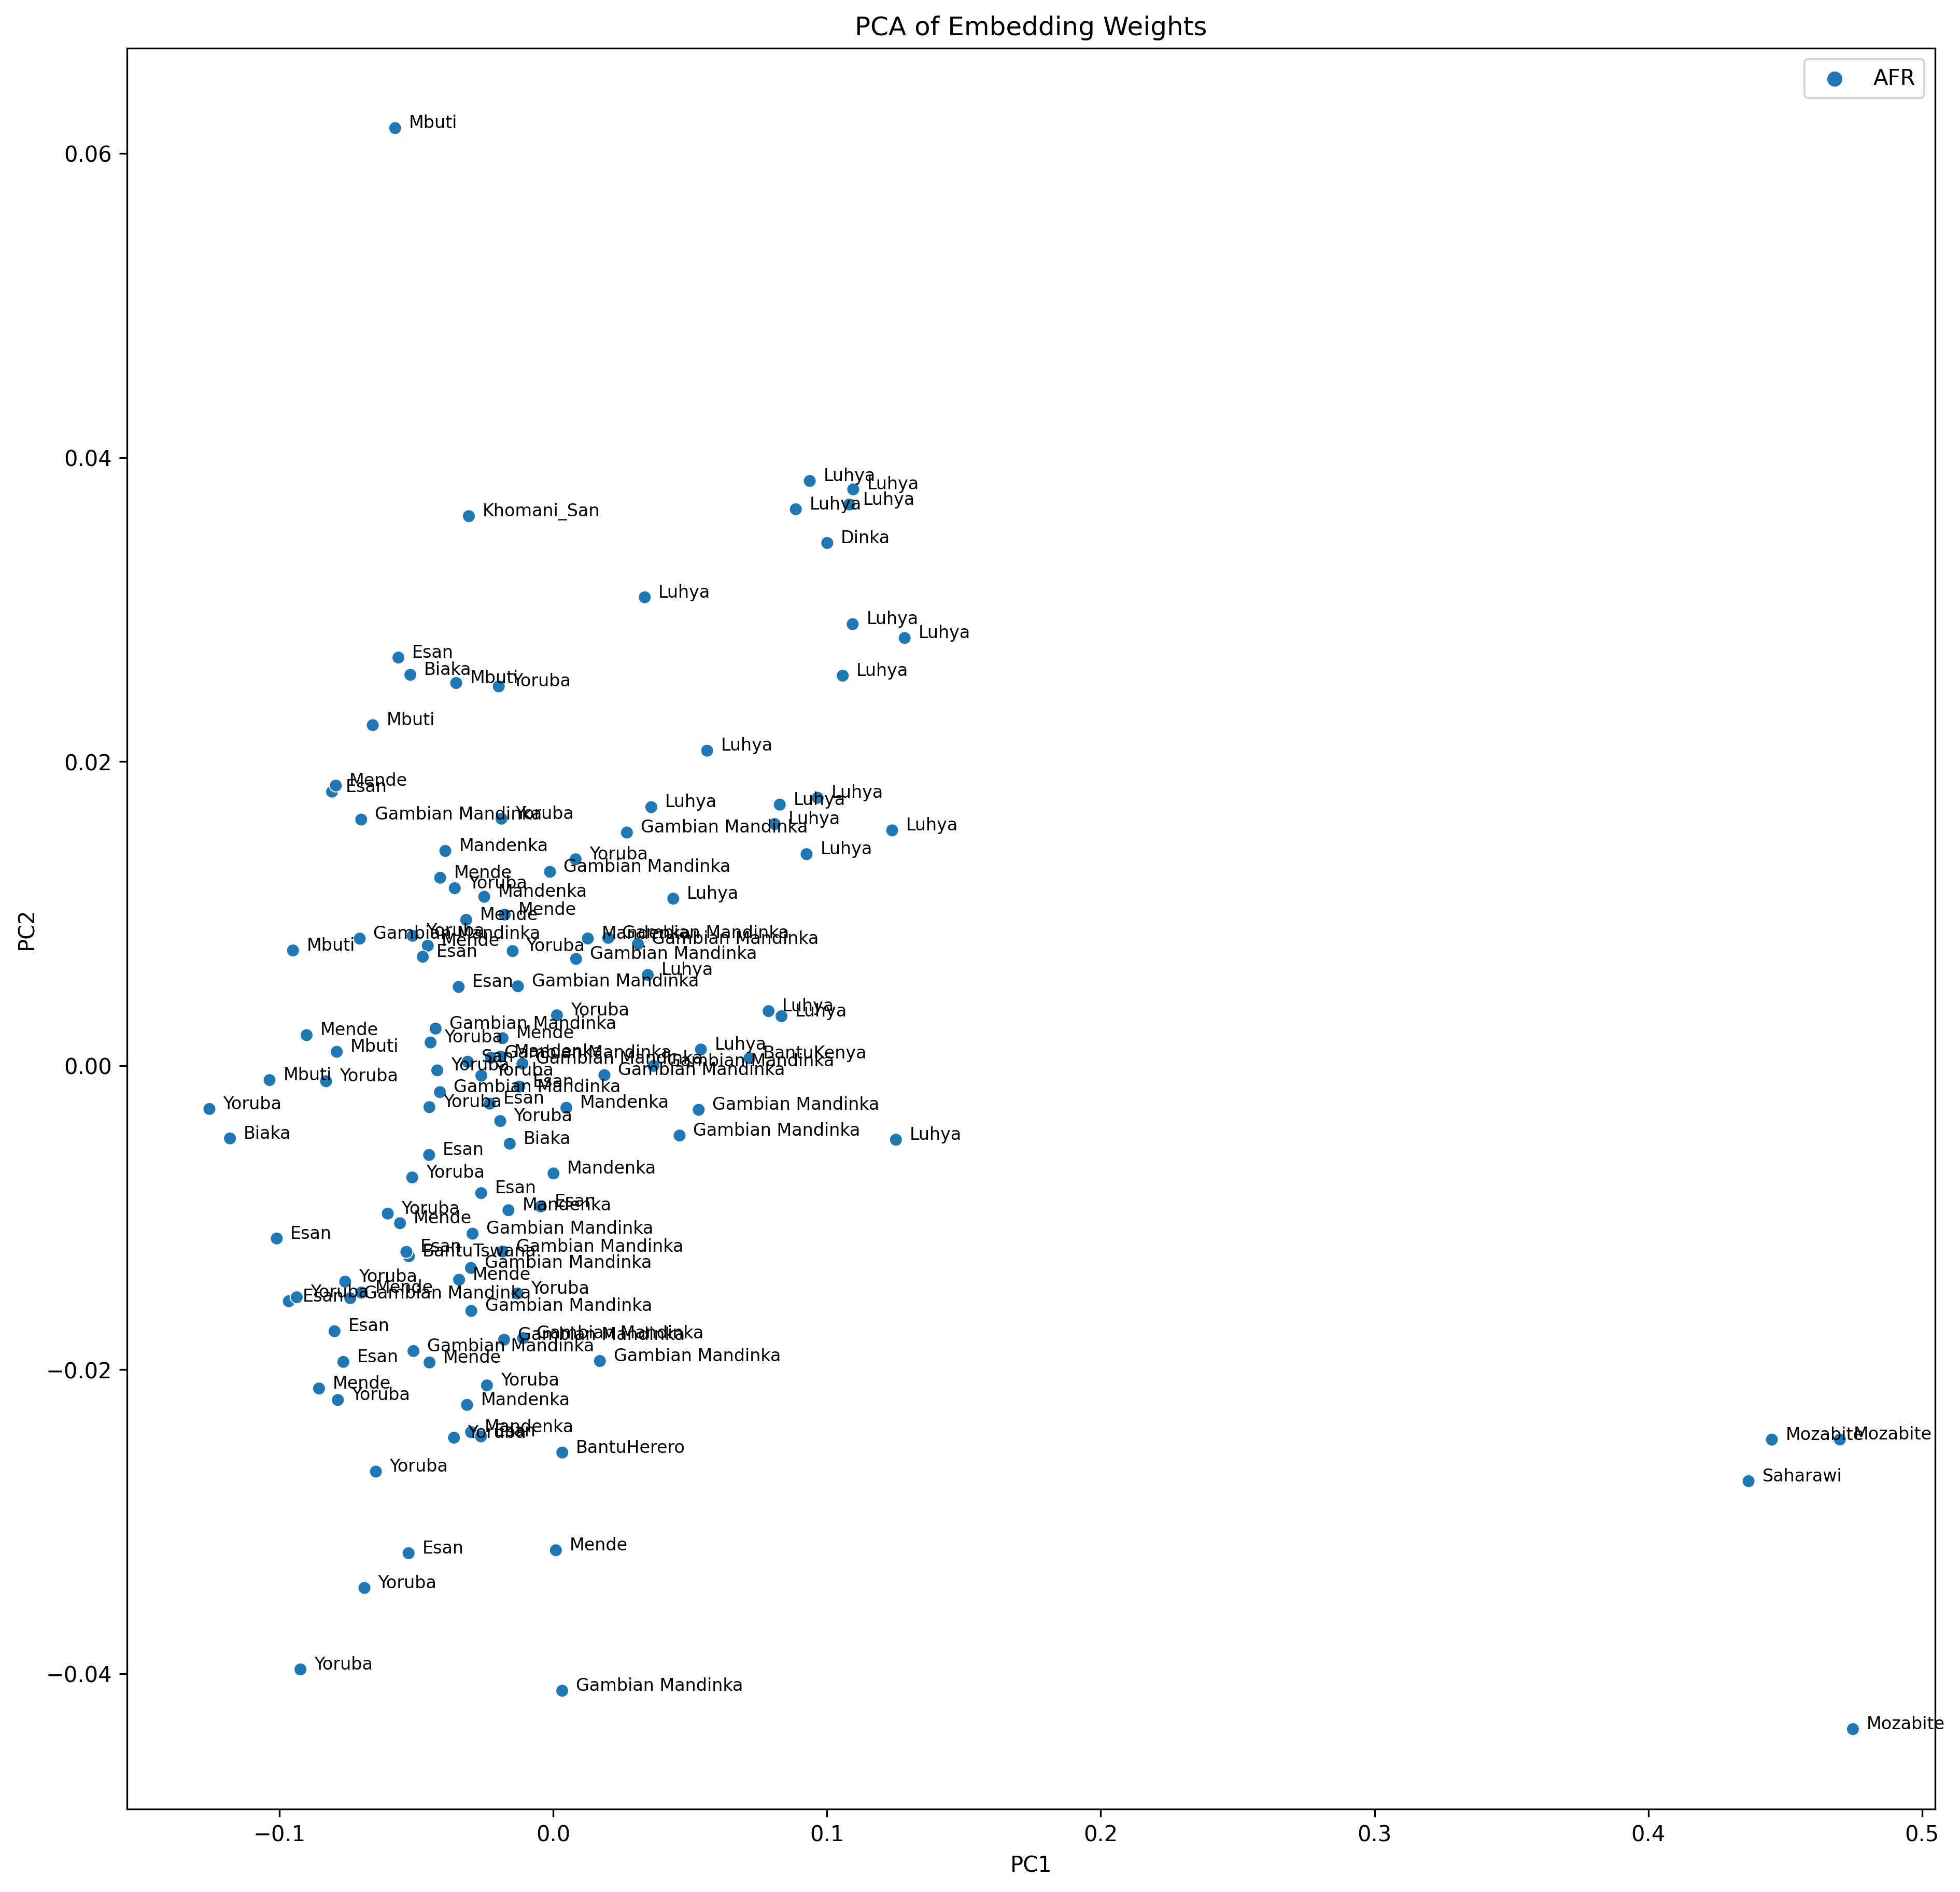

In [16]:
plt.figure(figsize=[15, 15], dpi=300)
sp_full = [dataset.suppop_label_index[x] for x in suppop_labels]
p_full = [dataset.pop_label_index[x] for x in pop_labels]
plot_weights_pca(embeddings, sp_full, p_full)
# plt.xlim(-0.25, 0.25)
# plt.ylim(-0.4, -0.3)
plt.show()

In [9]:
testpca = PCA()
testpca.fit_transform(embeddings)

array([[ 0.0925447 ,  0.0139109 ,  0.01326159, ...,  0.00534095,
        -0.00738305,  0.00281799],
       [ 0.12836996,  0.02813054,  0.00975493, ...,  0.00940948,
         0.00393771,  0.00137844],
       [-0.01633882, -0.00951065,  0.02422765, ..., -0.01466551,
         0.0074075 , -0.0008891 ],
       ...,
       [-0.04137921, -0.00174217,  0.00893938, ...,  0.00135547,
        -0.00228436,  0.00873206],
       [ 0.01264336,  0.00836365,  0.01934257, ...,  0.00870611,
        -0.0005954 ,  0.01118134],
       [-0.01891188,  0.01624367, -0.01791648, ...,  0.00475449,
         0.00385456,  0.00072095]], dtype=float32)

In [10]:
testpca.explained_variance_[:10]

array([1.00634415e-02, 3.51661205e-04, 2.56272207e-04, 1.71778942e-04,
       1.23495294e-04, 9.58702221e-05, 8.72907767e-05, 6.12824733e-05,
       5.06825418e-05, 3.91516405e-05], dtype=float32)